<a href="https://colab.research.google.com/github/viktorcikojevic/dipolar-droplets/blob/main/critical_atom_number.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import random
from numpy import loadtxt
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

import scipy.special
from scipy.optimize import fmin


In [2]:
# Get QMC data
import gdown

url = 'https://drive.google.com/uc?id=1RrM7HvxheAc7hO1sZUiJu0LdBrvr3u9L'
gdown.download(url, "energies-qmc.zip", quiet=False)

url = "https://drive.google.com/uc?id=1P_gBl2XgPKTweoVxLQcyi2brr9_H5gNB"
gdown.download(url, "experimental-data.zip", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1RrM7HvxheAc7hO1sZUiJu0LdBrvr3u9L
To: /Users/viktorcikojevic/Documents/dipolar-droplets/energies-qmc.zip
100%|██████████| 94.2k/94.2k [00:00<00:00, 2.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P_gBl2XgPKTweoVxLQcyi2brr9_H5gNB
To: /Users/viktorcikojevic/Documents/dipolar-droplets/experimental-data.zip
100%|██████████| 2.36k/2.36k [00:00<00:00, 3.12MB/s]


'experimental-data.zip'

In [3]:
!unzip -n energies-qmc.zip
!unzip -n experimental-data.zip

Archive:  energies-qmc.zip
   creating: energies-qmc/
  inflating: __MACOSX/._energies-qmc  
  inflating: energies-qmc/as80.dat   
  inflating: __MACOSX/energies-qmc/._as80.dat  
  inflating: energies-qmc/as100.dat  
  inflating: __MACOSX/energies-qmc/._as100.dat  
  inflating: energies-qmc/as110.dat  
  inflating: __MACOSX/energies-qmc/._as110.dat  
  inflating: energies-qmc/.DS_Store  
  inflating: energies-qmc/as90.dat   
  inflating: __MACOSX/energies-qmc/._as90.dat  
   creating: energies-qmc/data_clean/
  inflating: __MACOSX/energies-qmc/._data_clean  
   creating: energies-qmc/data_clean_C6/
  inflating: __MACOSX/energies-qmc/._data_clean_C6  
  inflating: energies-qmc/as60.dat   
  inflating: __MACOSX/energies-qmc/._as60.dat  
  inflating: energies-qmc/as70.dat   
  inflating: __MACOSX/energies-qmc/._as70.dat  
  inflating: energies-qmc/data_clean/as80.dat  
  inflating: __MACOSX/energies-qmc/data_clean/._as80.dat  
  inflating: energies-qmc/data_clean/as100.dat  
  inflating: 

# Functions for $n_c$ estimation

In [26]:


def fdip(x):
    x  = x + 0.*1j
    EPS = 1.E-10
    res = np.piecewise(x, [np.abs(x-1) < EPS, np.abs(x-1) >= EPS], [0.+0.j, lambda x: (1 + 2.*x**2) / (1 - x**2) - 3*x**2*np.arctanh(np.sqrt(1-x**2)) / (1 - x**2)**1.5])
    return res.real 


def enFit(x, b, c):
    return b*x**c


def en_harmonic_oscillator(sr, sz):
     # calculate energy of the quantum harmonic oscillator with N particles and harmonic length harmonic_length
    return 0.5 * (sr**2 / 10000**2 + sz**2 / 100000**2)


def en(sr, sz, nparticles, alpha, beta, gamma, include_ho=True):
      kappa = sr / sz
      kin = 0.25 * (2./sr**2 + 1./sz**2) 
      N = nparticles
      # en_int = N*alpha/((2*np.pi)**(3./2) * sr**2 * sz)  + N/(2*(2*np.pi)**1.5 * sr**2 * sz) * (- 4*np.pi/3 * fdip(kappa) ) + beta*np.power(N, gamma) / np.power(gamma+1., 3./2) /np.power(sr*sr *sz, gamma) / np.power(np.pi, 3*gamma/2)
      en_mflhy = np.sqrt(2)*np.pi**(-1.5)*N*alpha/(4*sr**2*sz) + np.pi**(-1.5*gamma)*beta*np.exp(gamma*np.log(N) - 2*gamma*np.log(sr) - gamma*np.log(sz))/(gamma + 1)**(3/2)
      en_int  = en_mflhy +  N/(2*(2*np.pi)**1.5 * sr**2 * sz) * (- 4*np.pi/3 * fdip(kappa) ) 
      en_per_particle =  kin   + en_int  + (en_harmonic_oscillator(sr, sz) if include_ho else 0)
      return np.min(en_per_particle)

def estimate_critical_atom_number(alpha, beta, gamma, include_ho=True):
    # Critical atom number is the number of atoms for which the energy of a system crosses zero.
    # The energy of a system is given by the second element of the tuple returned by en_particles.
    # The first element of the tuple is the optimal x_0.
    # Implement the root-finding algorithm to find the critical atom number
    # The function should return the critical atom number and the optimal x_0 for that atom number
    # The function should also return the energy of the system for the critical atom number.
    nparticles = 3*10**5

    ng = 200
    sr_range = np.linspace(4, 100, ng)
    sz_range = np.linspace(4, 800, ng)
    # make meshgrid
    sr, sz = np.meshgrid(sr_range, sz_range)

    

    iter_num = 0
    while True:
        nparticles_new = nparticles * 0.98
        en_0 = en(sr, sz, nparticles, alpha, beta, gamma, include_ho=include_ho)
        en_1 = en(sr, sz, nparticles_new, alpha, beta, gamma, include_ho=include_ho)
        if en_0 * en_1 < 0 and en_0 < 0 and en_1 > 0:
            break
        nparticles = nparticles_new
        iter_num += 1
        if iter_num > 4000:
            # Raise value error
            raise ValueError("Too many iterations")
            break
    nc = nparticles
    return nc, en_0

## Physics parameters

In [27]:
a_s = 91.401702191
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# r_0 = 393.14   # https://www.wolframalpha.com/input?i=%28162+atomic+mass+unit%29+*+%28mu_0%29+*+%2810+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# r_0 = 398 # https://www.wolframalpha.com/input?i=%28164+atomic+mass+unit%29+*+%28mu_0%29+*+%2810+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# From Raul’s Thesis: m is the atomic mass, and Cdd = μ0 μ^2 sets the strength of the dipolar
# interaction, with μ = 9.93μB the magnetic dipole moment of 162Dy. We use dipolar units,
# obtained from the characteristic dipolar length r0 = m C_dd/ (4π \hbar^2) = 387.672168a0 and the
# dipolar scale of energy 0 = ~2
# 

## Test the $N_c$ function

In [6]:
# These are the MF+LHY estimations from IGOR. Let's try to reproduce some of these
!cat experimental-data/mean_field_IGOR.dat  

#a	N
60.5970075184  550.962558145
62.7356641274  630.484693517
64.8743207365  721.484505403
66.7271283591  798.254461363
68.8657849681  913.469004347
70.8615170839  1027.84403302
72.7158135034  1176.19595118
74.853725714  1323.46689853
76.9931267214  1540.22653908
78.9896032357  1762.532214
80.5587950671  1983.2180518
82.6974516761  2269.46206612
84.5532368924  2686.04636111
87.4057715689  3288.07864054
89.4044812784  3957.78164425
91.401702191  4605.99379639
93.9721098732  5930.74447925
96.3988486638  7383.40961091
98.2561226769  9038.277145
99.8275477035  10697.3506182



In [7]:


a_s = a_s / r_0
alpha = 2*np.pi*a_s # * (1 - 1 / (3*(a_s / r_0)))
beta = 256*np.sqrt(np.pi)*a_s**(5/2)/15 + 128*np.sqrt(np.pi)*np.sqrt(a_s)/45
gamma = 1.5

n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, include_ho=False)
n_c_best_possible_fit, min_energy

(6539.133720934334, -1.0610516796283808e-05)

In [ ]:
ng = 200
sr_range = np.linspace(4, 100, ng)
sz_range = np.linspace(4, 400, ng)
# make meshgrid
sr, sz = np.meshgrid(sr_range, sz_range)
nparticles = 2200

en(sr, sz, nparticles, alpha, beta, gamma, include_ho=True)

-0.008186166889906286

In [ ]:
# r_0 = 360.375
a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]

# Recipe 1: E/N

Text(0.5, 1.0, 'E/N')

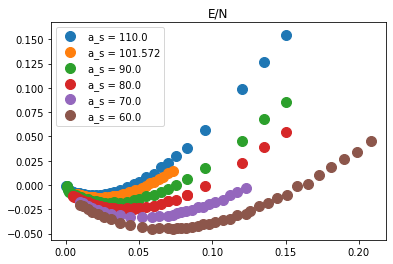

In [ ]:
a_s
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    # plot en_dip, empty markers, but same colors as above. Make empty circles
    # plt.plot(rho_all, en_dip , marker='o', markersize=10, linestyle='None', markerfacecolor='none', markeredgecolor=plt.gca().lines[-1].get_color())
    
    
    plt.errorbar(rho_all, en_all , sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
plt.legend()
plt.title("E/N")
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Recipe 2: $E/N - \alpha_{\rm MF} \rho$

Text(0.5, 1.0, 'E/N - alpha_mf * rho')

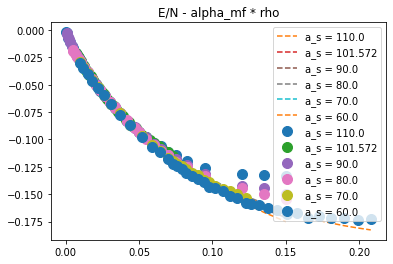

In [ ]:
a_s
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    # plot en_dip, empty markers, but same colors as above. Make empty circles
    # plt.plot(rho_all, en_dip , marker='o', markersize=10, linestyle='None', markerfacecolor='none', markeredgecolor=plt.gca().lines[-1].get_color())
    
    
    plt.errorbar(rho_all, en_all - alpha_mf * rho_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    def enFit(x, a, b, c):
        return a*x + b*x**c
    popt, pcov = curve_fit(enFit, rho_all[rho_all<0.05] , en_all[rho_all<0.05] - alpha_mf * rho_all[rho_all<0.05],sigma=sen_all[rho_all<0.05], maxfev=10000)
    
    # Sort rho_all
    rho_all_sorted = np.sort(rho_all)
    plt.plot(rho_all_sorted, enFit(rho_all_sorted, *popt), label=f"a_s = {a_s[i]}", markeredgecolor=plt.gca().lines[-1].get_color(), linestyle='--')
    
    
plt.legend()
plt.title("E/N - alpha_mf * rho")
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Recipe 3: $E/N - \alpha_{\rm Cherny} \rho$

(0.0, 0.2)

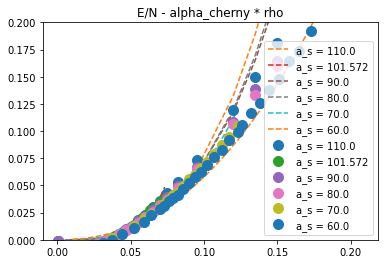

In [ ]:
a_s
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    # plot en_dip, empty markers, but same colors as above. Make empty circles
    # plt.plot(rho_all, en_dip , marker='o', markersize=10, linestyle='None', markerfacecolor='none', markeredgecolor=plt.gca().lines[-1].get_color())
    
    
    plt.errorbar(rho_all, en_all - alpha_cherny * rho_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    def enFit(x, b, c):
        return b*x**c
    popt, pcov = curve_fit(enFit, rho_all , en_all - alpha_cherny * rho_all,sigma=sen_all, maxfev=10000)
    
    # Sort rho_all
    rho_all_sorted = np.sort(rho_all)
    plt.plot(rho_all_sorted, enFit(rho_all_sorted, *popt), label=f"a_s = {a_s[i]}", markeredgecolor=plt.gca().lines[-1].get_color(), linestyle='--')
    
    
plt.legend()
plt.title("E/N - alpha_cherny * rho")
plt.ylim(0, 0.2)
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Recipe 4: STEP 1: Fit the energy to a function of the form $\alpha \rho + \beta\rho^\gamma$. Step 2: subtract the energy from the popt[0] * $\rho$

110.0 [-1.70961362  7.84530199]
101.572 [-1.76643893  7.57242701]
90.0 [-1.92827889  7.15272629]
80.0 [-2.08835696  7.06241259]
70.0 [-2.04557653  5.94348875]
60.0 [-2.1050044   5.31955915]


(0.0, 0.21837499999999999)

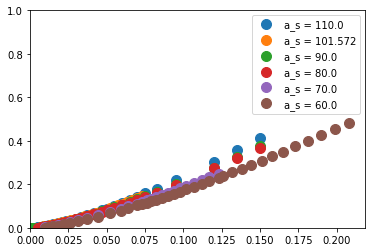

In [ ]:
 
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    # STEP 1: Fit the energy to a function of the form a*x + b*x**c
    def enFit(x, a, b):
        return a*x + b*x**1.5
    popt, pcov = curve_fit(enFit, rho_all , en_all,sigma=sen_all, maxfev=10000)
    
    # Step 2: subtract the energy from the popt[0] * rho
    print(a_s[i], popt)
    # Step 2: 
    en_all = en_all - popt[0] * rho_all 
    
    plt.errorbar(rho_all, en_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
        

    
plt.legend()
plt.ylim(0, 1)
plt.xlim(0)
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Recipe 5: STEP 1: Fit the $E/N-E_{\rm dip}/N$ to a function of the form $\alpha \rho + \beta\rho^\gamma$. Step 2: subtract the $\alpha \rho$ from the $E/N-E_{\rm dip}/N$.



a_s = 110.0, popt[alpha,beta,gamma]=[0.07914026 4.30471125 1.48835675],alpha_mf=1.9178644017752466, beta_mf=1.7747215329254704
*** 2: a_s = 110.0, popt[beta,gamma]=[4.30471124 1.48835674],alpha_mf=1.9178644017752466, beta_mf=1.7747215329254704


a_s = 101.572, popt[alpha,beta,gamma]=[0.12714962 3.93590047 1.50206361],alpha_mf=1.7709211183374125, beta_mf=1.4277893440772194
*** 2: a_s = 101.572, popt[beta,gamma]=[3.93590047 1.50206361],alpha_mf=1.7709211183374125, beta_mf=1.4277893440772194


a_s = 90.0, popt[alpha,beta,gamma]=[-0.24506008  3.08332493  1.32326093],alpha_mf=1.5691617832706561, beta_mf=1.0310599205665325
*** 2: a_s = 90.0, popt[beta,gamma]=[3.0833257  1.32326101],alpha_mf=1.5691617832706561, beta_mf=1.0310599205665325


a_s = 80.0, popt[alpha,beta,gamma]=[0.02890038 2.88996402 1.41993763],alpha_mf=1.3948104740183611, beta_mf=0.7542822703335726
*** 2: a_s = 80.0, popt[beta,gamma]=[2.88996432 1.41993767],alpha_mf=1.3948104740183611, beta_mf=0.7542822703335726


a_s = 70.0,

(0.0, 0.21837499999999999)

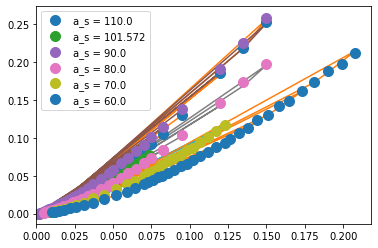

In [ ]:
 
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    # STEP 1: Fit the energy to a function of the form a*x + b*x**c
    def enFit(x, a, b, c):
        return a*x + b*x**c
    popt, pcov = curve_fit(enFit, rho_all , en_all - en_dip,sigma=sen_all, maxfev=10000)
    
    beta_mf = 32*4*np.pi*(a_s[i]/r_0)*np.sqrt((a_s[i]/r_0)**3) / (3 * np.sqrt(np.pi)) * (1. + 1.5*  ((a_s[i]/r_0))**2) * 2./5 

    print(f"\n\na_s = {a_s[i]}, popt[alpha,beta,gamma]={popt},alpha_mf={alpha_mf}, beta_mf={beta_mf}")
    # Step 2: 
    en_all = en_all - popt[0] * rho_all - en_dip
    def enFit(x, b, c):
        return b*x**c
    popt, pcov = curve_fit(enFit, rho_all , en_all,sigma=sen_all, maxfev=10000)
    plt.errorbar(rho_all, en_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    plt.plot(rho_all, enFit(rho_all, *popt))
    print(f"*** 2: a_s = {a_s[i]}, popt[beta,gamma]={popt},alpha_mf={alpha_mf}, beta_mf={beta_mf}")
        

    
plt.legend()
# plt.ylim(0, 3)
plt.xlim(0)
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Recipe 6: STEP 1: Fit the $E/N$ to a function of the form $\alpha \rho + \beta\rho^\gamma$. Step 2: Replace $\alpha$ by $\alpha_{\rm Cherny}$



a_s = 110.0, popt[alpha,beta,gamma]=[83.59485507  3.0411306 ],alpha_mf=1.9178644017752466, beta_mf=1.7747215329254704


a_s = 101.572, popt[alpha,beta,gamma]=[1.52453073e+04 4.84124423e+00],alpha_mf=1.7709211183374125, beta_mf=1.4277893440772194


a_s = 90.0, popt[alpha,beta,gamma]=[53.54340085  2.88628688],alpha_mf=1.5691617832706561, beta_mf=1.0310599205665325


a_s = 80.0, popt[alpha,beta,gamma]=[62.74351608  2.95211722],alpha_mf=1.3948104740183611, beta_mf=0.7542822703335726


a_s = 70.0, popt[alpha,beta,gamma]=[42.03455432  2.79598216],alpha_mf=1.220459164766066, beta_mf=0.5314845611434388


a_s = 60.0, popt[alpha,beta,gamma]=[9.85211494 2.23131348],alpha_mf=1.0461078555137708, beta_mf=0.35637543529923077


(0.0, 0.21837499999999999)

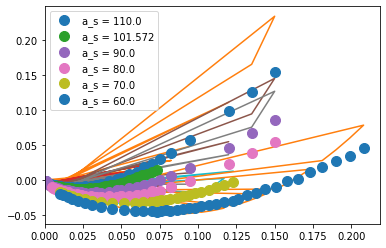

In [ ]:
 
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    alpha_cherny    = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
    # plt.errorbar(rho_all, en_all - alpha_mf * rho_all,sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    
    en_dip = data[:,7]
    
    plt.errorbar(rho_all, en_all, sen_all, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    # STEP 1: Fit the energy to a function of the form a*x + b*x**c
    def enFit(x, b, c):
        return alpha_cherny*x + b*x**c
    popt, pcov = curve_fit(enFit, rho_all , en_all,sigma=sen_all, maxfev=10000)
    
    beta_mf = 32*4*np.pi*(a_s[i]/r_0)*np.sqrt((a_s[i]/r_0)**3) / (3 * np.sqrt(np.pi)) * (1. + 1.5*  ((a_s[i]/r_0))**2) * 2./5 

    print(f"\n\na_s = {a_s[i]}, popt[alpha,beta,gamma]={popt},alpha_mf={alpha_mf}, beta_mf={beta_mf}")
    plt.plot(rho_all, enFit(rho_all, *popt))
        

    
plt.legend()
# plt.ylim(0, 3)
plt.xlim(0)
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Estimate $n_c$ with recipe 5

In [ ]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir recipe-5-nc
fout = open(f"recipe-5-nc/functionals_E_N.dat", 'w', buffering=1)
# fout.write("# {rho_min_x} {a_s[i]} {popt[0]} {popt[1]} {popt[2]} {n_c}\n")
for rho_min_x in np.arange(0.6, 0.7, 0.1):
  for rho_max_x in np.arange(1.5, 1.6, 0.1):
    for i in range(len(a_s)):
        rho_min = rho_min_x * rho_0_arr
        rho_max = rho_max_x * rho_0_arr


        print("analyzing a_s = %.e" % (a_s[i]))

        data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
        print("Reading data", "energies-qmc/" + file[i])
        rho_all = data[:, 0]
        en_all = data[:, 1] #  -  data[:,7]
        sen_all = data[:, 2]  # - data[:,6]
        en_dip = data[:,7]

        en_all = en_all - en_dip

        w = np.logical_and(rho_all > rho_min[i], rho_all < rho_max[i])
        rho_all_w = rho_all[w]
        en_all_w = en_all[w]
        sen_all_w = sen_all[w]

        try:
            
            alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
            alpha_cherny = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            
            def enFit(x, a, b, c):
              return a*x + b*x**c
            
            popt, pcov = curve_fit(enFit, rho_all_w, en_all_w,sigma=sen_all_w, maxfev=10000)
            alpha, beta, gamma = popt
            n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma)
            
            
            
            alpha_opt = popt[0]
            # popt[0] = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            # n_c_alpha_cherny = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0)  
            # n_c_alpha_mf = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0) / 10  
            # n_c_alpha_mf_over_10 = estimate_critical_atom_number(popt)

            # string_out = f"{rho_min_x} {a_s[i]} {alpha_opt} {popt[1]} {popt[2]} {n_c_best_possible_fit} {n_c_alpha_cherny} {n_c_alpha_mf} {n_c_alpha_mf_over_10} \n"
            string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e}  {min_energy:.5e}   \n"
            fout.write(string_out)
            print(string_out)
        except Exception as error:
            print('Caught this error: ' + repr(error))


mkdir: cannot create directory ‘recipe-5-nc’: File exists
analyzing a_s = 1e+02
Reading data energies-qmc/as110.dat
110.00 2.47549e+02  3.62500e-01 3.62500e-01 1.23251e+01  -4.11426e-04   

analyzing a_s = 1e+02
Reading data energies-qmc/as100.dat
101.57 2.23413e+02  1.28373e-01 1.28373e-01 3.65692e+00  -4.53172e-04   

analyzing a_s = 9e+01
Reading data energies-qmc/as90.dat
90.00 2.01631e+02  4.58238e-01 4.58238e-01 1.26589e+01  -1.06636e-04   

analyzing a_s = 8e+01
Reading data energies-qmc/as80.dat
80.00 1.81972e+02  3.56650e-01 3.56650e-01 4.24779e+00  -1.56440e-04   

analyzing a_s = 7e+01
Reading data energies-qmc/as70.dat
70.00 1.64229e+02  -7.45310e-01 -7.45310e-01 2.69799e+00  -5.57585e-04   

analyzing a_s = 6e+01
Reading data energies-qmc/as60.dat
60.00 1.56018e+02  4.67638e-01 4.67638e-01 3.50230e+00  -5.83599e-04   

analyzing a_s = 1e+02
Reading data energies-qmc/as110.dat
110.00 2.35172e+02  5.48812e-02 5.48812e-02 3.97459e+00  -2.00819e-04   

analyzing a_s = 1e+02
Re

# Estimate $n_c$ with recipe 1

In [ ]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir recipe-1-nc
fout = open(f"recipe-1-nc/functionals_E_N.dat", 'w', buffering=1)
# fout.write("# {rho_min_x} {a_s[i]} {popt[0]} {popt[1]} {popt[2]} {n_c}\n")
for rho_min_x in np.arange(0.6, 0.7, 0.1):
  for rho_max_x in np.arange(1.5, 1.6, 0.1):
    for i in range(len(a_s)):
        rho_min = rho_min_x * rho_0_arr
        rho_max = rho_max_x * rho_0_arr


        print("analyzing a_s = %.e" % (a_s[i]))

        data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
        print("Reading data", "energies-qmc/" + file[i])
        rho_all = data[:, 0]
        en_all = data[:, 1] #  -  data[:,7]
        sen_all = data[:, 2]  # - data[:,6]
        en_dip = data[:,7]

        en_all = en_all

        w = np.logical_and(rho_all > rho_min[i], rho_all < rho_max[i])
        rho_all_w = rho_all[w]
        en_all_w = en_all[w]
        sen_all_w = sen_all[w]

        try:
            
            alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
            alpha_cherny = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            
            def enFit(x, a, b, c):
              return a*x + b*x**c
            
            popt, pcov = curve_fit(enFit, rho_all_w, en_all_w,sigma=sen_all_w, maxfev=10000)
            alpha, beta, gamma = popt
            n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma)
            
            
            
            alpha_opt = popt[0]
            # popt[0] = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            # n_c_alpha_cherny = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0)  
            # n_c_alpha_mf = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0) / 10  
            # n_c_alpha_mf_over_10 = estimate_critical_atom_number(popt)

            # string_out = f"{rho_min_x} {a_s[i]} {alpha_opt} {popt[1]} {popt[2]} {n_c_best_possible_fit} {n_c_alpha_cherny} {n_c_alpha_mf} {n_c_alpha_mf_over_10} \n"
            string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e}  {min_energy:.5e}   \n"
            fout.write(string_out)
            print(string_out)
        except Exception as error:
            print('Caught this error: ' + repr(error))


mkdir: cannot create directory ‘recipe-1-nc’: File exists
analyzing a_s = 1e+02
Reading data energies-qmc/as110.dat
110.00 5.59302e+01  -4.83061e+00 -4.83061e+00 7.31149e+00  -1.97772e-04   

analyzing a_s = 1e+02
Reading data energies-qmc/as100.dat
101.57 5.04770e+01  -2.52497e+01 -2.52497e+01 2.69411e+01  -7.52255e-04   

analyzing a_s = 9e+01
Reading data energies-qmc/as90.dat
90.00 4.32777e+01  -2.06369e+00 -2.06369e+00 6.02757e+00  -1.99201e-04   

analyzing a_s = 8e+01
Reading data energies-qmc/as80.dat
80.00 3.71052e+01  -1.19347e+01 -1.19347e+01 1.35168e+01  -4.36492e-06   

analyzing a_s = 7e+01
Reading data energies-qmc/as70.dat
70.00 3.34875e+01  -3.46976e+01 -3.46976e+01 3.59712e+01  -8.38832e-04   

analyzing a_s = 6e+01
Reading data energies-qmc/as60.dat
60.00 3.18131e+01  -3.00390e+00 -3.00390e+00 5.03255e+00  -1.25843e-03   

analyzing a_s = 1e+02
Reading data energies-qmc/as110.dat
110.00 5.59302e+01  -3.78921e+01 -3.78921e+01 3.96828e+01  -3.61260e-04   

analyzing a_

# Estimate $n_c$ with recipe 3

In [ ]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir recipe-3-nc
fout = open(f"recipe-3-nc/functionals_E_N.dat", 'w', buffering=1)
# fout.write("# {rho_min_x} {a_s[i]} {popt[0]} {popt[1]} {popt[2]} {n_c}\n")
for rho_min_x in np.arange(0.6, 0.7, 0.1):
  for rho_max_x in np.arange(1.5, 1.6, 0.1):
    for i in range(len(a_s)):
        rho_min = rho_min_x * rho_0_arr
        rho_max = rho_max_x * rho_0_arr


        print("analyzing a_s = %.e" % (a_s[i]))

        data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
        print("Reading data", "energies-qmc/" + file[i])
        rho_all = data[:, 0]
        en_all = data[:, 1] #  -  data[:,7]
        sen_all = data[:, 2]  # - data[:,6]
        en_dip = data[:,7]

        en_all = en_all

        w = np.logical_and(rho_all > rho_min[i], rho_all < rho_max[i])
        rho_all_w = rho_all[w]
        en_all_w = en_all[w]
        sen_all_w = sen_all[w]

        try:
            
            alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
            alpha_cherny = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            
            def enFit(x, a, b, c):
              return a*x + b*x**c
            
            en_all_w = en_all_w - alpha_cherny * rho_all_w

            popt, pcov = curve_fit(enFit, rho_all_w, en_all_w,sigma=sen_all_w, maxfev=10000)
            alpha, beta, gamma = popt
            n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma)
            
            
            
            alpha_opt = popt[0]
            # popt[0] = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            # n_c_alpha_cherny = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0)  
            # n_c_alpha_mf = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0) / 10  
            # n_c_alpha_mf_over_10 = estimate_critical_atom_number(popt)

            # string_out = f"{rho_min_x} {a_s[i]} {alpha_opt} {popt[1]} {popt[2]} {n_c_best_possible_fit} {n_c_alpha_cherny} {n_c_alpha_mf} {n_c_alpha_mf_over_10} \n"
            string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e}  {min_energy:.5e}   \n"
            fout.write(string_out)
            print(string_out)
        except Exception as error:
            print('Caught this error: ' + repr(error))


mkdir: cannot create directory ‘recipe-3-nc’: File exists
analyzing a_s = 1e+02
Reading data energies-qmc/as110.dat
110.00 6.52342e+01  -4.65410e+00 -4.65410e+00 7.31151e+00  -1.56084e-04   

analyzing a_s = 1e+02
Reading data energies-qmc/as100.dat
101.57 6.52342e+01  -2.48934e+01 -2.48934e+01 2.69083e+01  -1.06403e-04   

analyzing a_s = 9e+01
Reading data energies-qmc/as90.dat
90.00 6.86676e+01  -1.53846e+00 -1.53846e+00 6.02756e+00  -2.81404e-04   

analyzing a_s = 8e+01
Reading data energies-qmc/as80.dat
80.00 6.52342e+01  -1.12345e+01 -1.12345e+01 1.35162e+01  -3.17078e-04   

analyzing a_s = 7e+01
Reading data energies-qmc/as70.dat
70.00 6.52342e+01  -3.39156e+01 -3.39156e+01 3.60631e+01  -6.22808e-04   

analyzing a_s = 6e+01
Reading data energies-qmc/as60.dat
60.00 6.86676e+01  -1.95561e+00 -1.95561e+00 5.03255e+00  -6.34127e-04   

analyzing a_s = 1e+02
Reading data energies-qmc/as110.dat
110.00 6.52342e+01  -3.77178e+01 -3.77178e+01 3.96850e+01  -2.91614e-04   

analyzing a_

# Estimate $n_c$ with recipe 6

In [ ]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir recipe-6-nc
fout = open(f"recipe-6-nc/functionals_E_N.dat", 'w', buffering=1)
# fout.write("# {rho_min_x} {a_s[i]} {popt[0]} {popt[1]} {popt[2]} {n_c}\n")
for rho_min_x in np.arange(0.6, 0.7, 0.1):
  for rho_max_x in np.arange(1.5, 1.6, 0.1):
    for i in range(len(a_s)):
        rho_min = rho_min_x * rho_0_arr
        rho_max = rho_max_x * rho_0_arr


        print("analyzing a_s = %.e" % (a_s[i]))

        data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
        print("Reading data", "energies-qmc/" + file[i])
        rho_all = data[:, 0]
        en_all = data[:, 1] #  -  data[:,7]
        sen_all = data[:, 2]  # - data[:,6]
        en_dip = data[:,7]

        en_all = en_all

        w = np.logical_and(rho_all > rho_min[i], rho_all < rho_max[i])
        rho_all_w = rho_all[w]
        en_all_w = en_all[w]
        sen_all_w = sen_all[w]

        try:
            
            alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
            alpha_cherny = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            
            def enFit(x, b, c):
              return b*x**c
            
            en_all_w = en_all_w  - alpha_cherny * rho_all_w
            
            popt, pcov = curve_fit(enFit, rho_all_w, en_all_w,sigma=sen_all_w, maxfev=10000)
            beta, gamma = popt
            alpha = alpha_cherny
            n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma)
            
            
            
            alpha_opt = popt[0]
            # popt[0] = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            # n_c_alpha_cherny = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0)  
            # n_c_alpha_mf = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0) / 10  
            # n_c_alpha_mf_over_10 = estimate_critical_atom_number(popt)

            # string_out = f"{rho_min_x} {a_s[i]} {alpha_opt} {popt[1]} {popt[2]} {n_c_best_possible_fit} {n_c_alpha_cherny} {n_c_alpha_mf} {n_c_alpha_mf_over_10} \n"
            string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e}  {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e}  {min_energy:.5e}   \n"
            fout.write(string_out)
            print(string_out)
        except Exception as error:
            print('Caught this error: ' + repr(error))


mkdir: cannot create directory ‘recipe-6-nc’: File exists
analyzing a_s = 1e+02
Reading data energies-qmc/as110.dat
Caught this error: ValueError('Too many iterations')
analyzing a_s = 1e+02
Reading data energies-qmc/as100.dat
101.57 5.59302e+01  -3.23474e-01 -1.35431e+00 6.96216e+00  -1.65963e-03   

analyzing a_s = 9e+01
Reading data energies-qmc/as90.dat
Caught this error: RuntimeError('Optimal parameters not found: Number of calls to function has reached maxfev = 10000.')
analyzing a_s = 8e+01
Reading data energies-qmc/as80.dat
80.00 4.55555e+01  -6.99585e-01 1.81745e+06 6.34197e+00  -8.76487e-04   

analyzing a_s = 7e+01
Reading data energies-qmc/as70.dat
70.00 3.90581e+01  -8.73936e-01 6.87133e+02 3.76814e+00  -6.14550e-05   

analyzing a_s = 6e+01
Reading data energies-qmc/as60.dat
60.00 3.71052e+01  -1.04829e+00 2.54265e+01 2.57304e+00  -7.47670e-04   

analyzing a_s = 1e+02
Reading data energies-qmc/as110.dat
Caught this error: ValueError('Too many iterations')
analyzing a_s =

# Estimate $n_c$ with recipe 42: MFLHY

In [28]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir recipe-42-nc
fout = open(f"recipe-42-nc/functionals_E_N.dat", 'w', buffering=1)
# fout.write("# {rho_min_x} {a_s[i]} {popt[0]} {popt[1]} {popt[2]} {n_c}\n")
for i in range(len(a_s)):
    print("analyzing a_s = %.e" % (a_s[i]))
    try:        
        alpha = 2*np.pi*(a_s[i]/r_0) # * (1 - 1 / (3*(a_s / r_0)))
        beta = 256*np.sqrt(np.pi)*(a_s[i]/r_0)**(5/2)/15 + 128*np.sqrt(np.pi)*np.sqrt((a_s[i]/r_0))/45

        gamma = 1.5
        n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma)
        string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e}   \n"
        fout.write(string_out)
        print(string_out)
    except Exception as error:
        print('Caught this error: ' + repr(error))


mkdir: recipe-42-nc: File exists
analyzing a_s = 1e+02
Caught this error: ValueError('Too many iterations')
analyzing a_s = 1e+02
101.57 2.55095e+04   

analyzing a_s = 9e+01
90.00 6.45767e+03   

analyzing a_s = 8e+01
80.00 2.82062e+03   

analyzing a_s = 7e+01
70.00 1.39078e+03   

analyzing a_s = 6e+01
60.00 7.58647e+02   



# Estimate $n_c$ with recipe 43: Cherny

In [ ]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir recipe-43-nc
fout = open(f"recipe-43-nc/functionals_E_N.dat", 'w', buffering=1)
# fout.write("# {rho_min_x} {a_s[i]} {popt[0]} {popt[1]} {popt[2]} {n_c}\n")
for i in range(len(a_s)):
    print("analyzing a_s = %.e" % (a_s[i]))

    try:        
        alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
        alpha_cherny = 2*np.pi*(a_s[i] / r_0) * (1 - 1 / (3*(a_s[i] / r_0)))
        beta_mf = 32*4*np.pi*(a_s[i]/r_0)*np.sqrt((a_s[i]/r_0)**3) / (3 * np.sqrt(np.pi)) * (1. + 1.5*  ((a_s[i]/r_0))**2) * 2./5 
        
        alpha = alpha_cherny
        beta = beta_mf
        gamma = 1.5
        n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma)
        string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e}   \n"
        fout.write(string_out)
        print(string_out)
    except Exception as error:
        print('Caught this error: ' + repr(error))


mkdir: cannot create directory ‘recipe-43-nc’: File exists
analyzing a_s = 1e+02
110.00 8.43058e+01   

analyzing a_s = 1e+02
101.57 6.86676e+01   

analyzing a_s = 9e+01
90.00 5.59302e+01   

analyzing a_s = 8e+01
80.00 4.55555e+01   

analyzing a_s = 7e+01
70.00 4.11138e+01   

analyzing a_s = 6e+01
60.00 3.71052e+01   



# Plot critical atom number

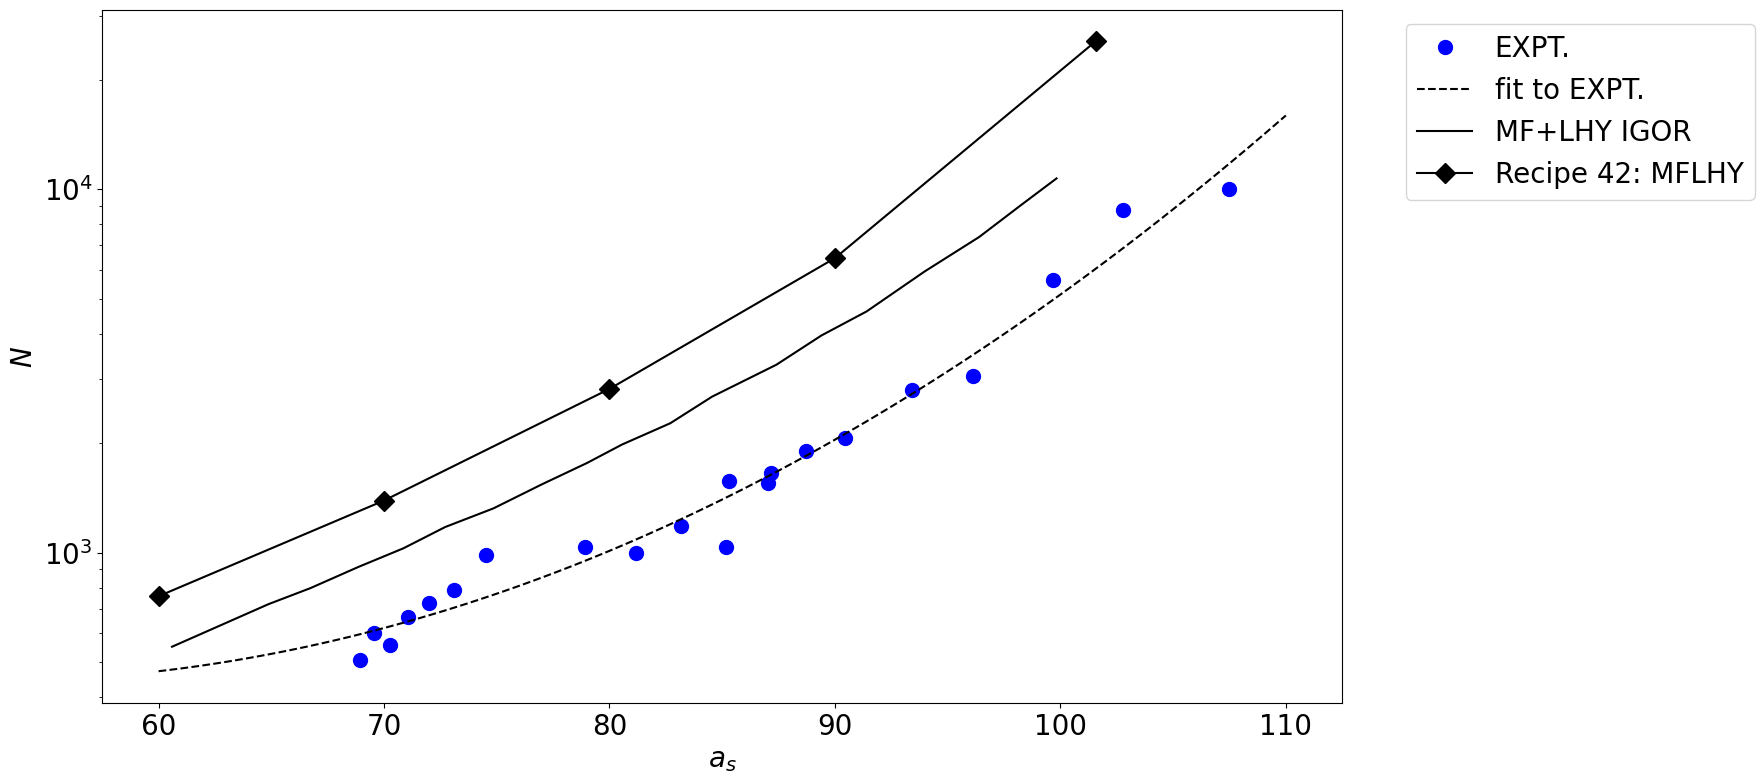

In [29]:

plt.figure(figsize=(16, 9))

def log_func_fit(x, a, b, c):
    return a*x**2 + b*x + c
def func_fit(x, a, b, c):
    return np.exp(log_func_fit(x, a, b, c))
data = np.loadtxt("./experimental-data/combined-critical-atom-number.dat")
sclen_expt = data[:,0]
nc_expt = data[:,1]
popt, pcov = curve_fit(f=log_func_fit, xdata=sclen_expt, ydata=np.log(nc_expt))

plt.plot(sclen_expt, nc_expt, label="EXPT.", ls='', marker='o', color='blue', markersize=10)
x = np.linspace(60, 110, num = 100)
plt.plot(x, func_fit(x, popt[0], popt[1], popt[2]), label="fit to EXPT.", color='black', ls = '--', markersize=10)


mf_data = np.loadtxt("./experimental-data/mean_field_IGOR.dat")
sclen_mf = mf_data[:,0]
nc_mf = mf_data[:,1]
plt.plot(sclen_mf, nc_mf, label="MF+LHY IGOR", color='black', markersize=10)

# data = np.loadtxt("./recipe-1-nc/functionals_E_N.dat")
# sclen = data[:,0]
# nc = data[:,1]
# plt.plot(sclen, nc, label="Recipe 1", color='blue', marker='D', ls='', markersize=10)

# data = np.loadtxt("./recipe-3-nc/functionals_E_N.dat")
# sclen = data[:,0]
# nc = data[:,1]
# plt.plot(sclen, nc, label="Recipe 3", color='green', marker='D', ls='', markersize=10)

# data = np.loadtxt("./recipe-5-nc/functionals_E_N.dat")
# sclen = data[:,0]
# nc = data[:,1]
# plt.plot(sclen, nc, label="Recipe 5", color='red', marker='D', ls='', markersize=10)

# data = np.loadtxt("./recipe-6-nc/functionals_E_N.dat")
# sclen = data[:,0]
# nc = data[:,1]
# plt.plot(sclen, nc, label="Recipe 6", color='orange', marker='D', ls='', markersize=10)


data = np.loadtxt("./recipe-42-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 42: MFLHY", color='black', marker='D', ls='-', markersize=10)


# data = np.loadtxt("./recipe-43-nc/functionals_E_N.dat")
# sclen = data[:,0]
# nc = data[:,1]
# plt.plot(sclen, nc, label="Recipe 43: Cherny", color='pink', marker='D', ls='', markersize=10)


plt.xlabel(r'$a_s$', fontsize=20)
plt.ylabel(r'$N$', fontsize=20)
plt.legend(loc = "best", bbox_to_anchor=(1.04, 1), fontsize=20)

plt.yscale('log')
# plt.ylim(1, 200000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Save the figure into plots folder
plt.savefig(f"plots/recipe-42-nc.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"plots/recipe-42-nc.png", bbox_inches='tight', dpi=300)
